## setup

In [1]:
import torch
import intel_extension_for_pytorch as ipex

C:\Users\intel\miniforge3\envs\bertviz\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\intel\miniforge3\envs\bertviz\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
C:\Users\intel\miniforge3\envs\bertviz\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import  AutoTokenizer,AutoModelForCausalLM

model_name ='EleutherAI/gpt-neo-2.7B'#'gpt2'#'bert-base-uncased' #neo takes longer to load but is a bit more clever
model=AutoModelForCausalLM.from_pretrained(model_name).to('xpu')
tokenizer = AutoTokenizer.from_pretrained(model_name)

model

C:\Users\intel\miniforge3\envs\bertviz\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 2560)
    (wpe): Embedding(2048, 2560)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-31): 32 x GPTNeoBlock(
        (ln_1): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=2560, out_features=2560, bias=False)
            (v_proj): Linear(in_features=2560, out_features=2560, bias=False)
            (q_proj): Linear(in_features=2560, out_features=2560, bias=False)
            (out_proj): Linear(in_features=2560, out_features=2560, bias=True)
          )
        )
        (ln_2): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=2560, out_features=10240, bias=True)
          (c_proj)

In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from bertviz import head_view

# code

## tokenizing and padding

### tokenizing

tokenizing is when we take in an input string and turn it into a sequnce of integers representing the string.

gpt2 uses BPE for its tokenizer, which works by taking frequntly ocuring sequnces and give them 1 token.

In [4]:
print(tokenizer.encode('hi there'))
print(tokenizer.encode('uqp'))
print(tokenizer.encode(''))

[5303, 612]
[84, 80, 79]
[]


### padding

there r generally 2 ways of dealing with padding:
1. add a special pad token
2. use an existing token and let the mask handle it

we will use the second because dealing with an extra token is tricky

In [5]:
#for gpt this is needed bert this breaks
tokenizer.pad_token_id=tokenizer.eos_token_id

In [6]:
inputs=tokenizer(['hi',"hi I am longer"], return_tensors='pt',padding=True)
inputs = {k:v.to('xpu') for k,v in inputs.items()}
inputs

{'input_ids': tensor([[ 5303, 50256, 50256, 50256],
         [ 5303,   314,   716,  2392]], device='xpu:0'),
 'attention_mask': tensor([[1, 0, 0, 0],
         [1, 1, 1, 1]], device='xpu:0')}

In [7]:
tokenizer.__dict__.keys()

dict_keys(['_tokenizer', '_decode_use_source_tokenizer', 'init_inputs', 'init_kwargs', 'name_or_path', '_processor_class', 'model_max_length', 'padding_side', 'truncation_side', 'model_input_names', 'clean_up_tokenization_spaces', 'split_special_tokens', 'deprecation_warnings', '_in_target_context_manager', 'chat_template', '_bos_token', '_eos_token', '_unk_token', '_sep_token', '_pad_token', '_cls_token', '_mask_token', '_pad_token_type_id', '_additional_special_tokens', 'verbose', 'add_bos_token', 'add_prefix_space'])

In [8]:
tokenizer._tokenizer.__dict__.keys()

dict_keys([])

In [9]:
with torch.no_grad():
    output=model(**inputs)
output.logits.shape

torch.Size([2, 4, 50257])

In [10]:
#gpt
x=inputs['input_ids']
print(x.shape,x.dtype)
model.transformer.wte(x).shape

torch.Size([2, 4]) torch.int64


torch.Size([2, 4, 2560])

In [11]:
# #bert
# x=inputs['input_ids']
# print(x.shape,x.dtype)
# model.bert.embeddings.word_embeddings(x).shape

### bertviz

In [31]:
inputs=tokenizer(['victor was a rider and he went to'],return_tensors='pt')
tokens = [tokenizer.decode([token_id]) for token_id in inputs['input_ids'][0]]

inputs = {k:v.to('xpu') for k,v in inputs.items()}
with torch.no_grad():
    output=model(**inputs,output_attentions=True)
attention = [x.to('xpu') for x in output.attentions]

head_view(attention, tokens)

<IPython.core.display.Javascript object>

### attention

attention is the core idea behind a transformer.

it tells the model which token is the most important to look at

we will now visualize some of the avrages between multiple layers and attention heads. 

just to get a feel for it

In [13]:
inputs=tokenizer(['victor was a rider and he went to'],return_tensors='pt')
inputs = {k:v.to('xpu') for k,v in inputs.items()}
with torch.no_grad():
    output=model(**inputs,output_attentions=True)
[x.shape for x in output.attentions]

[torch.Size([1, 20, 9, 9]),
 torch.Size([1, 20, 9, 9]),
 torch.Size([1, 20, 9, 9]),
 torch.Size([1, 20, 9, 9]),
 torch.Size([1, 20, 9, 9]),
 torch.Size([1, 20, 9, 9]),
 torch.Size([1, 20, 9, 9]),
 torch.Size([1, 20, 9, 9]),
 torch.Size([1, 20, 9, 9]),
 torch.Size([1, 20, 9, 9]),
 torch.Size([1, 20, 9, 9]),
 torch.Size([1, 20, 9, 9]),
 torch.Size([1, 20, 9, 9]),
 torch.Size([1, 20, 9, 9]),
 torch.Size([1, 20, 9, 9]),
 torch.Size([1, 20, 9, 9]),
 torch.Size([1, 20, 9, 9]),
 torch.Size([1, 20, 9, 9]),
 torch.Size([1, 20, 9, 9]),
 torch.Size([1, 20, 9, 9]),
 torch.Size([1, 20, 9, 9]),
 torch.Size([1, 20, 9, 9]),
 torch.Size([1, 20, 9, 9]),
 torch.Size([1, 20, 9, 9]),
 torch.Size([1, 20, 9, 9]),
 torch.Size([1, 20, 9, 9]),
 torch.Size([1, 20, 9, 9]),
 torch.Size([1, 20, 9, 9]),
 torch.Size([1, 20, 9, 9]),
 torch.Size([1, 20, 9, 9]),
 torch.Size([1, 20, 9, 9]),
 torch.Size([1, 20, 9, 9])]

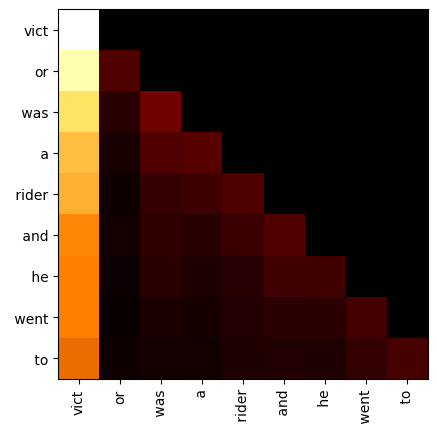

In [14]:
heatmap=torch.stack(output.attentions).mean(dim=(0,1,2)).detach().cpu().numpy()
plt.imshow(heatmap,cmap='afmhot')

tokens = [tokenizer.decode([token_id]) for token_id in inputs['input_ids'][0]]


# Label the axes with the decoded tokens
plt.xticks(range(len(tokens)), tokens, rotation=90)
plt.yticks(range(len(tokens)), tokens)
plt.show()

In [15]:
heatmap.sum(1)

array([1.        , 1.0000001 , 1.        , 1.        , 0.99999994,
       0.99999994, 1.        , 1.        , 1.0000001 ], dtype=float32)

In [16]:
@torch.no_grad
def show_atten(prompt,depth=12,letters=True):
  inputs=tokenizer([prompt],return_tensors='pt')
  inputs = {k:v.to('xpu') for k,v in inputs.items()}
    
  output=model(**inputs,output_attentions=True)

  heatmap=torch.stack(output.attentions[:depth]).mean(dim=(0,1,2)).detach().cpu().numpy()
  plt.imshow(heatmap,cmap='afmhot')

  if(not letters):
    return
  tokens = [tokenizer.decode([token_id]) for token_id in inputs['input_ids'][0]]

  # Label the axes with the decoded tokens
  plt.xticks(range(len(tokens)), tokens, rotation=90)
  plt.yticks(range(len(tokens)), tokens)


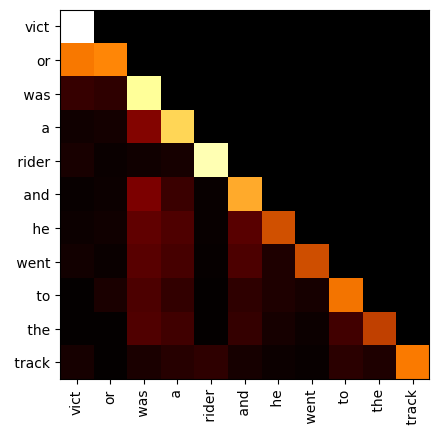

In [17]:
show_atten('victor was a rider and he went to the track',1)

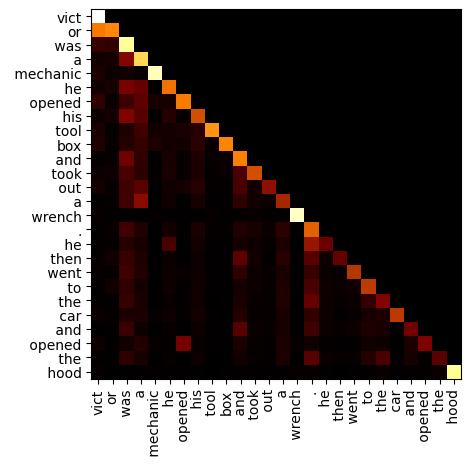

In [18]:
show_atten('victor was a mechanic he opened his toolbox and took out a wrench. he then went to the car and opened the hood',1)

In [19]:
wikipedia_philosophy='''Philosophy (love of wisdom in ancient Greek) is a systematic study of general and fundamental questions concerning topics like existence, reason, knowledge, value, mind, and language. It is a rational and critical inquiry that reflects on its own methods and assumptions.

Historically, many of the individual sciences, like physics and psychology, formed part of philosophy. But they are considered separate academic disciplines in the modern sense of the term. The main traditions in the history of philosophy include Western, Arabic-Persian, Indian, and Chinese philosophy. Western philosophy originated in Ancient Greece and covers a wide area of philosophical subfields. A central topic in Arabic-Persian philosophy is the relation between reason and revelation. Indian philosophy combines the spiritual problem of how to reach enlightenment with the exploration of the nature of reality and the ways of arriving at knowledge. Chinese philosophy focuses on practical issues in relation to right social conduct, government, and self-cultivation.

Major branches of philosophy are epistemology, ethics, logic, and metaphysics. Epistemology studies what knowledge is and how to acquire it. Ethics investigates moral principles and what constitutes right conduct. Logic is the study of correct reasoning and explores how good arguments can be distinguished from bad ones. Metaphysics examines the most general features of reality, existence, objects, and properties. Other notable subfields are aesthetics, philosophy of language, philosophy of mind, philosophy of religion, philosophy of science, philosophy of history, and political philosophy.

Philosophers use a great variety of methods to arrive at philosophical knowledge. They include conceptual analysis, reliance on common sense and intuitions, use of thought experiments, analysis of ordinary language, description of experience, and critical questioning. Philosophy is related to many other fields, like the sciences, mathematics, business, law, and journalism. It provides an interdisciplinary perspective and studies their scope and fundamental concepts. It also investigates their methods and ethical implications'''


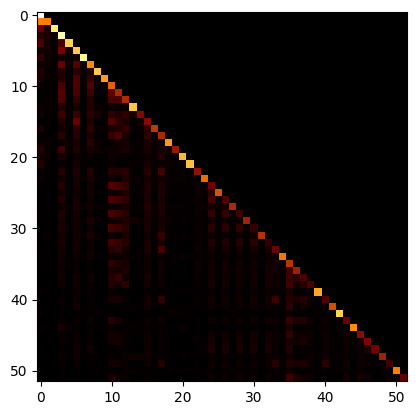

In [20]:
show_atten(wikipedia_philosophy.split('\n\n')[0],1,False)

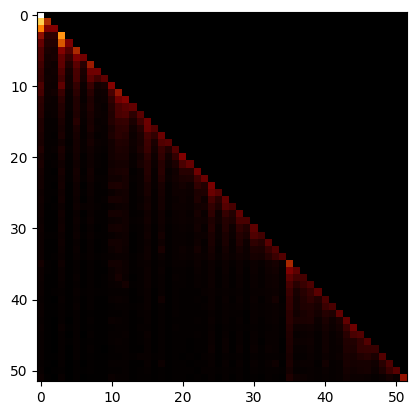

In [21]:
show_atten(wikipedia_philosophy.split('\n\n')[0],7,False)

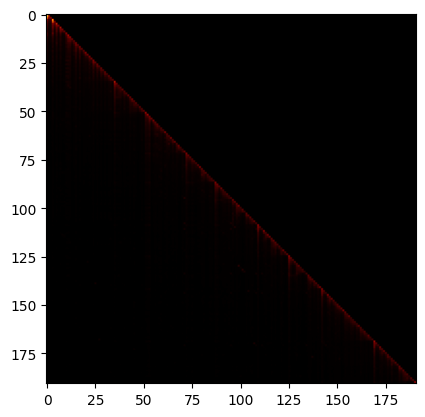

In [22]:
show_atten('\n\n'.join(wikipedia_philosophy.split('\n\n')[:2]),7,False)

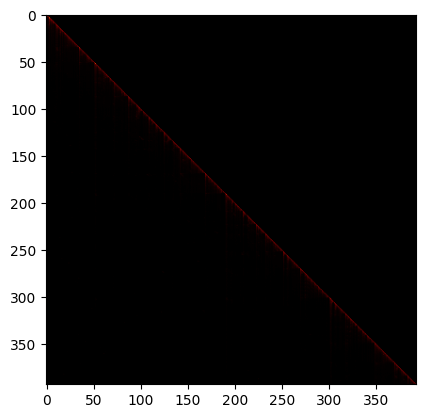

In [23]:
show_atten(wikipedia_philosophy,12,False)

# gpt2 deep dive:

gpt2 and above are a take on the transformer architecture from "attention is all you need".

they simplfy and change the original architecture. (note that alot of online reasources get the diagram wrong)

.

this can be abit overwhelming at first and its okay if you dont get a full grasp on it right away.

especially with how there are small variation in implementation

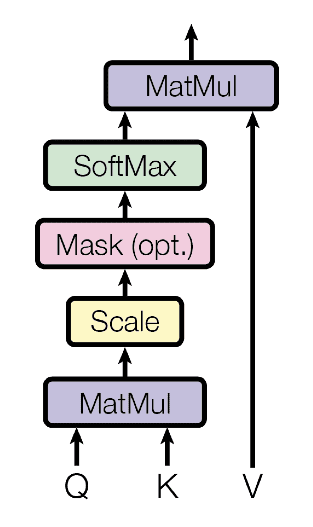

### positional encoding

the attention layer has now way of knowing the order of words in the sentance.

and since the mlp layer is just a linear layer applied to each token.

a tramsformer has no way of knowing where tokens are located


.

to fix this issue we use positional encoding

its a vector that is added for each position in the sequnce.

there are 2 versions:

1. give each position a trainble vector

2. use premade constant vectors (usually made with cosine and sin to alow for extention to any sequnce length)

gpt2 uses the first one.

In [ ]:
positional_embeding=model.transformer.wpe
positional_embeding

In [ ]:
plt.imshow(positional_embeding(torch.arange(1024)).detach(),cmap='seismic')
plt.colorbar()

### transformer

this is a diagram of gpt2's architecture

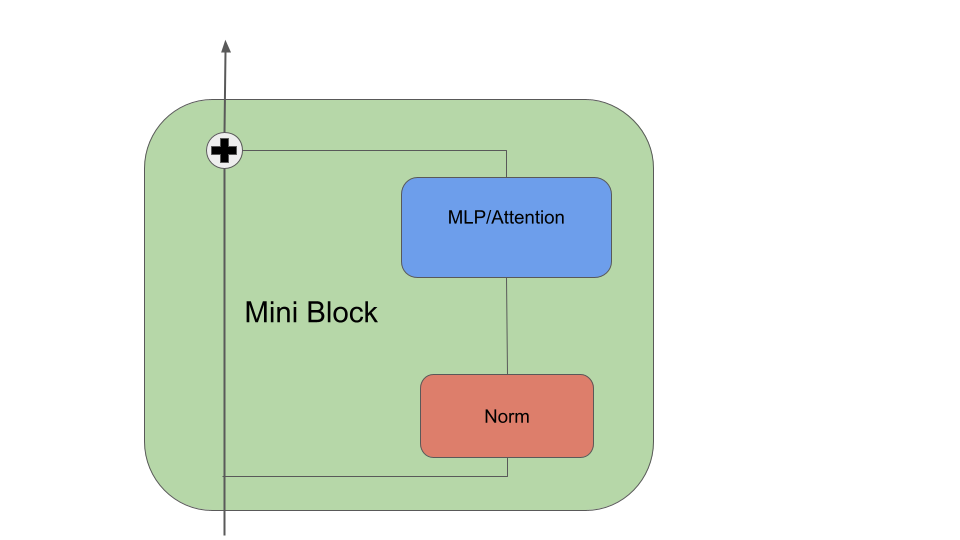

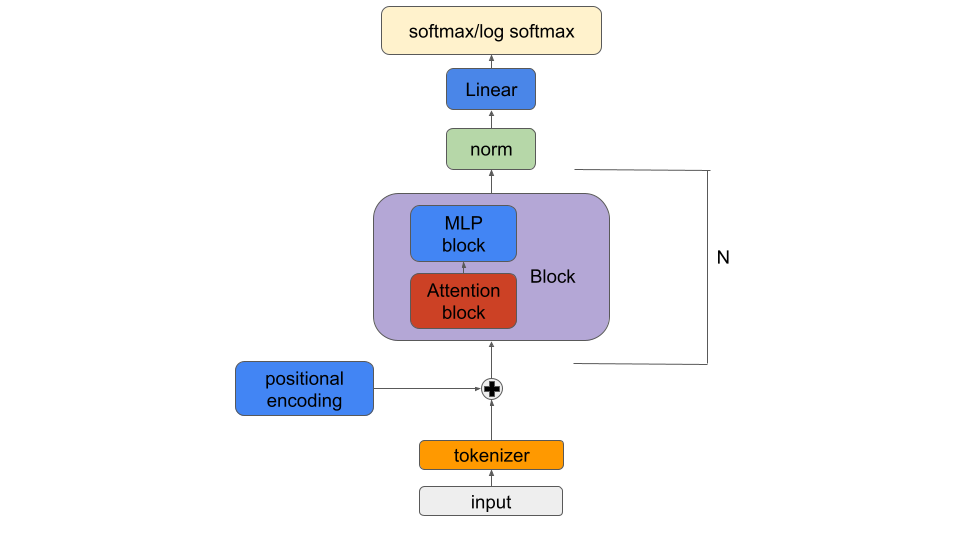

notice that norm is always called before atten and mlp.

this desgin choice is the genuise behind gpt2 it alows the gradients to flow mostly linearly backwards which alows for faster learning

there is another small technical diffrence and thats the last softmax.
in huggingface this layer is not part of the model to alow us to work more acurately with the log probabileties if we want.

## paper

here is the actual code from the paper on how a block is implemented

https://github.com/openai/gpt-2/blob/master/src/model.py

In [ ]:
def multihead_attn(q, k, v):
        # q, k, v have shape [batch, heads, sequence, features]
        w = tf.matmul(q, k, transpose_b=True)
        w = w * tf.rsqrt(tf.cast(v.shape[-1].value, w.dtype))

        w = mask_attn_weights(w)
        w = softmax(w)
        a = tf.matmul(w, v)
        return a

In [ ]:
def mlp(x, scope, n_state, *, hparams):
    with tf.variable_scope(scope):
        nx = x.shape[-1].value
        h = gelu(conv1d(x, 'c_fc', n_state))
        h2 = conv1d(h, 'c_proj', nx)
        return h2


In [ ]:

def block(x, scope, *, past, hparams):
    with tf.variable_scope(scope):
        nx = x.shape[-1].value
        a, present = attn(norm(x, 'ln_1'), 'attn', nx, past=past, hparams=hparams)
        x = x + a
        m = mlp(norm(x, 'ln_2'), 'mlp', nx*4, hparams=hparams)
        x = x + m
        return x, present